# Parental Leave 
*** 

#### What regional differences are there with respect to paid parental leave policies for tenure track faculty members at North American colleges and universities?

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
from scipy.special import binom
import math
import itertools
%matplotlib inline
import matplotlib.lines as lines
import random
from scipy import stats

In [202]:
local_path = ''

file_path = local_path 

dfLeave = pd.read_table(local_path)
 
dfLeave.head()

,university_name,short_name,is_private,rank,rank_ind,census_region,missing,paid_leave_len_woman,paid_leave_len_woman_units,paid_leave_weeks_woman,relief_woman,paid_leave_len_man,paid_leave_len_man_units,paid_leave_weeks_man,relief_man,link,notes,date
0,Arizona State University,Arizona State,0,108.72,101,West,0,6.0,week,6.0,Not specified,6.0,week,6.0,Not specified,https://provost.asu.edu/academic-personnel/par...,.,2/22/18
1,Auburn University,Auburn,0,126.69,122,South,0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,https://cws.auburn.edu/shared/content/files/85/,FMLA,2/22/18
2,Boston University,Boston,1,51.73,44,Northeast,0,1.0,term,14.0,Other,1.0,term,14.0,Other,https://www.bu.edu/handbook/leaves-absences/fa...,"Full semester for either parent, relief is FUL...",2/22/18
3,Brandeis University,Brandeis,1,84.55,78,Northeast,0,12.0,week,12.0,Not specified,12.0,week,12.0,Not specified,https://www.brandeis.edu/humanresources/docume...,.,2/22/18
4,Brigham Young University,Brigham Young,1,166.53,180,West,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not publicly accessible,Staff leave is 6wk,2/22/18


**Part A**: I will begin by answering the following summary questions:
* How many institutions are in the dataset? 
* How many actually have parental leave data in the `paid_leave_len_woman` column? 
* How many private institutions are there? 
* How many institutions have a note associated with them?

In [203]:
institutions = dfLeave.shape[0]
print("There are", institutions, "institutions in the dataset")

S = [1 if dfLeave["paid_leave_len_woman"][i] >= 0 else 0 for i in range (dfLeave.shape[0])]
Bool = np.array(S).sum()
print("Number of institutions that actually have parental leave data:", Bool)

private = dfLeave["is_private"].sum()
print("Number of institutions that are private in the dataset:", private)

dfNote = dfLeave.loc[dfLeave["notes"] != ""]
dfNote = dfNote.loc[dfNote["notes"] != "."]
notes = dfNote.shape[0]
print("Number of institutions that have a note associated with them:", notes)

There are 205 institutions in the dataset
Number of institutions that actually have parental leave data: 197
Number of institutions that are private in the dataset: 53
Number of institutions that have a note associated with them: 174


**Part B**: Is there statistical evidence at the $\alpha=0.05$ level that public and private institutions have different _average paid parental leave durations_? 

I will answer this question separately for men and for women. 

First, I will clean the data to eliminate any NaN values in the relevant columns of the data frame.

In [204]:
dfLeaveC = dfLeave.drop(dfLeave.index[dfLeave["missing"]==1])
dfLeaveC.head()
dfLeaveC.shape[0]

197

Let $\mu$ be the difference in mean paid paternal leave (in weeks) for men and women at private and public schools. Then:

$$
\begin{array}{l}
H_0: \mu = 0  \\
H_1: \mu \neq 0  \\
\end{array}
$$

In this problem, I will use a two-tailed hypothesis test. I will also use z-scores, because we are testing sample means, which are normally distributed. Also, the data is sufficiently large, so we can rule out a t-test. 

I will break this problem up into smaller problems. First, I will extract the appropriate data for the mean time of paternal leave for men at public and private schools. Then I will compute a two-sided critical value $-z_\alpha = -z_{0.025}$ to compare their leave times. After I have made the relevant comparisons for men I will then do the same comparison for women before drawing my overall conclusion.

In [205]:
MenPrivate = dfLeaveC.loc[dfLeaveC["is_private"] == 1, "paid_leave_weeks_man"].mean()
print("Sample Mean for Men at Private Schools = {:.2f}".format(MenPrivate))
MenPublic = dfLeaveC.loc[dfLeaveC["is_private"] == 0, "paid_leave_weeks_man"].mean()
print("Sample Mean for Men at Public Schools = {:.2f}".format(MenPublic))

Sample Mean for Men at Private Schools = 8.92
Sample Mean for Men at Public Schools = 6.15


In [206]:
za = stats.norm.ppf(0.025)#0.025 instead of 0.975 because we want the positive end of the spectrum
print("-za = ", -za)

delta_mean = MenPrivate-MenPublic

stderrPrivate = dfLeaveC.loc[dfLeaveC["is_private"] == 1, "paid_leave_weeks_man"].std()/np.sqrt(48)
stderrPublic = dfLeaveC.loc[dfLeaveC["is_private"] == 0, "paid_leave_weeks_man"].std()/np.sqrt(149)

standardev = np.sqrt(stderrPrivate**2 + stderrPublic**2)
z = ((delta_mean)/standardev)
print("z = ", z)

-za =  1.95996398454
z =  2.34456338305


In [207]:
SampleSize = dfLeaveC['is_private'].value_counts()
print(SampleSize)

0    149
1     48
Name: is_private, dtype: int64


Since 2.34 is greater than 1.96, we can reject the null hypothesis. There is sufficient evidence to believe, at the 5% significance level, that the mean leave time is different for public and private schools for male employees.

Now that I have examined the issue for male employees, I will now turn to the issue of whether there is sufficient evidence to believe, at the 5% significance level, that the mean leave time is different for public and private schools for female employees.

In [208]:
WomenPrivate = dfLeaveC.loc[dfLeaveC["is_private"] == 1, "paid_leave_weeks_woman"].mean()
print("Sample Mean Time for Women at Private Schools = {:.2f}".format(WomenPrivate))
WomenPublic = dfLeaveC.loc[dfLeaveC["is_private"] == 0, "paid_leave_weeks_woman"].mean()
print("Sample Mean Time for Women at Public Schools = {:.2f}".format(WomenPublic))

Sample Mean Time for Women at Private Schools = 10.52
Sample Mean Time for Women at Public Schools = 8.20


In [209]:
za = stats.norm.ppf(0.025)#0.025 instead of 0.975 because we want the positive en of the spectrum
print("-za = ", -za)

delta_mean = WomenPrivate-WomenPublic

stderrPrivate = (dfLeaveC.loc[dfLeaveC["is_private"] == 1, "paid_leave_weeks_woman"].std())/np.sqrt(48)
stderrPublic = (dfLeaveC.loc[dfLeaveC["is_private"] == 0, "paid_leave_weeks_woman"].std())/np.sqrt(149)

standardev = np.sqrt(stderrPrivate**2 + stderrPublic**2)

z = (delta_mean)/standardev
print("z = ", z)

-za =  1.95996398454
z =  1.87069469913


Since 1.87 is not greater than 1.96, we do not reject the null hypothesis. There is not sufficient evidence to believe, at the 5% significance level, that the mean leave time is different for public and private schools for female employees.

Based on the fact that in one case, but not both, we rejected the Null hypothesis, I conclude that **we do have enough evidence to claim that public and private institutions have different average paid parental leave durations.**

**Part C**: Some institutions provide zero weeks of paid parental leave. So, for each `census_region` in the dataset, I will create a 95% confidence interval for the _proportion of universities that offer zero paid parental leave to their professors_. I will determine whether there is evidence that policies vary significantly by census region? 

In order to answer this question, I will begin by analyzing each region independently.  First, I will look at Canada. To analyze the data, I will create a separate Canadian dataframe.

In [210]:
web_path = ''
file_path = web_path 
dfLeave = pd.read_table(web_path)

In [211]:
dfCanada = dfLeave.loc[dfLeave["census_region"] == 'Canada'].copy()
dfCanada.head()

,university_name,short_name,is_private,rank,rank_ind,census_region,missing,paid_leave_len_woman,paid_leave_len_woman_units,paid_leave_weeks_woman,relief_woman,paid_leave_len_man,paid_leave_len_man_units,paid_leave_weeks_man,relief_man,link,notes,date
7,Carleton University,Carleton,0,101.73,93,Canada,0,12.0,week,12.0,Not specified,12.0,week,12.0,Not specified,https://carleton.ca/hr/wp-content/uploads/CUAS...,12 weeks paid + 5 weeks with the Employer payi...,2/22/18
18,"Concordia University, Montreal",Concordia,0,138.05,139,Canada,0,20.0,week,20.0,Not specified,5.0,day,1.0,Not specified,https://www.concordia.ca/content/dam/common/do...,Mothers paid at 93% of their usual salary.,2/22/18
21,Dalhousie University,Dalhousie,0,139.97,142,Canada,0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,https://cdn.dal.ca/content/dam/dalhousie/pdf/d...,"Continuous employment, for the purpose of dete...",2/22/18
44,McGill University,McGill,0,69.84,56,Canada,0,31.0,week,31.0,Not specified,12.0,week,12.0,Not specified,https://www.mcgill.ca/apo/academic-staff/proce...,Policy does not mention relief type; For men a...,2/24/18
45,McMaster University,McMaster,0,84.01,77,Canada,0,30.0,week,30.0,All duties,19.0,week,19.0,All duties,http://www.mcmaster.ca/policy/faculty/Appointm...,.,2/24/18


First, I will find preliminary values and then use a botstrap method to compute the confidence interval (CI), since the data for Canada is so small (<30) and non-normal.

In [239]:
dfCanada = dfCanada.dropna(subset=["paid_leave_len_woman"])
CaSample = np.array(dfCanada['paid_leave_len_woman'].tolist())
print(CaSample)

[ 12.  20.   0.  31.  30.   0.  35.  35.  15.   0.  18.  18.  50.  35.  30.
  36.  23.  24.  17.]


In [241]:
c = []
num_boots=5000
b = np.array([(np.random.choice(CaSample, replace=True, size=len(CaSample))) for ii in range(num_boots)])
for sample in b:
    zero_els = len(sample) - np.count_nonzero(sample)
    # get the proportion for the sample
    p = zero_els/len(sample)
    # append that proportion to c
    c.append(p)

L, U = np.percentile(c, 2.5), np.percentile(c, 97.5)
CI = np.array([L, U])

print("Lower CI:", L)
print("Upper CI:", U)

Lower CI: 0.0
Upper CI: 0.315789473684


Now, I will conduct a similar test for the north eastern region, but this time using z-values for the C.I.

In [242]:
dfNorth = dfLeave.loc[dfLeave["census_region"] == 'Northeast'].copy()

In [243]:
NorTotal = dfNorth.shape[0]
print("Total number of north-eastern schools in data set:", NorTotal)
NorNo = dfNorth.loc[dfNorth.paid_leave_len_woman == 0.0, "paid_leave_len_woman"].count()
print("Number of these institutions that actually have no parental leave:", NorNo)

Total number of north-eastern schools in data set: 45
Number of these institutions that actually have no parental leave: 13


In [244]:
NorProp = (NorNo/NorTotal)
z = stats.norm.ppf(0.975)
pn = NorProp

In [245]:
stderrn = np.sqrt((pn*(1-pn))/NorTotal)

Norlower = NorProp - (z)*(stderrn)
Norupper = NorProp + (z)*(stderrn)
print("Lower CI:", Norlower)
print("Upper CI:", Norupper)

Lower CI: 0.156462058118
Upper CI: 0.421315719659


Now, I will conduct a similar test for the midwest region and this time using z-values for the C.I.

In [246]:
dfMid = dfLeave.loc[dfLeave["census_region"] == 'Midwest'].copy()

In [247]:
MidTotal = dfMid.shape[0]
print("Total number of midwestern schools in data set:", MidTotal)
MidNo = dfMid.loc[dfMid.paid_leave_len_woman == 0.0, "paid_leave_len_woman"].count()
print("Number of these institutions that actually have no parental leave:", MidNo)

Total number of midwestern schools in data set: 38
Number of these institutions that actually have no parental leave: 16


In [248]:
MidProp = (MidNo/MidTotal)
z = stats.norm.ppf(0.975)
pm = MidProp

In [249]:
stderrm = np.sqrt((pm*(1-pm))/MidTotal)

Midlower = MidProp - (z)*(stderrm)
Midupper = MidProp + (z)*(stderrm)
print("Lower CI:", Midlower)
print("Upper CI:", Midupper)

Lower CI: 0.264072738901
Upper CI: 0.578032524257


Now, I will conduct a similar test for the southern region, using z-values for the C.I.

In [250]:
dfSouth = dfLeave.loc[dfLeave["census_region"] == 'South'].copy()
dfSouth = dfSouth.loc[dfSouth["missing"]!=1]
dfSouth.head()

,university_name,short_name,is_private,rank,rank_ind,census_region,missing,paid_leave_len_woman,paid_leave_len_woman_units,paid_leave_weeks_woman,relief_woman,paid_leave_len_man,paid_leave_len_man_units,paid_leave_weeks_man,relief_man,link,notes,date
1,Auburn University,Auburn,0,126.69,122,South,0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,https://cws.auburn.edu/shared/content/files/85/,FMLA,2/22/18
10,Catholic University of America,Catholic Univ. of America,1,151.04,158,South,0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,http://policies.cua.edu/employment/compensatio...,Up to sixteen (16) weeks unpaid leave in any t...,2/22/18
13,Clemson University,Clemson,0,151.45,159,South,0,1.0,term,16.0,Other,1.0,term,16.0,Other,http://media.clemson.edu/humanres/policies_pro...,Faculty will 'be given modified duties that ar...,2/22/18
14,College of William and Mary,William and Mary,0,75.20,62,South,0,120.0,day,24.0,Not specified,120.0,day,24.0,Not specified,https://www.wm.edu/about/administration/provos...,'available only when the faculty member is the...,2/22/18
25,Duke University,Duke,1,30.50,29,South,0,1.0,term,17.0,Not specified,1.0,term,17.0,Not specified,https://provost.duke.edu/sites/all/files/FHB_C...,'must indicate in writing to the dean and/or p...,2/22/18


In [251]:
SouthTotal = dfSouth.shape[0]
print("Total number of southern schools in data set:", SouthTotal)
SouthNo = dfSouth.loc[dfSouth.paid_leave_len_woman == 0.0, "paid_leave_len_woman"].count()
print("Number of these institutions that actually have no parental leave:", SouthNo)

Total number of southern schools in data set: 58
Number of these institutions that actually have no parental leave: 32


In [252]:
SProp = SouthNo/SouthTotal
z = stats.norm.ppf(0.975)
print(z)

1.95996398454


In [253]:
ps = SProp
stderrs = np.sqrt((ps*(1-ps))/SouthTotal)
print(stderrs)

0.0653009760654


In [254]:
#upper ci
uciS = SProp + (z)*(stderrs)
print("Upper CI:", uciS)

#lower ci
lciS = SProp - (z)*(stderrs)
print("Lower CI:", lciS)

Upper CI: 0.679711699174
Lower CI: 0.423736576688


Now, I will conduct a similar test for the western region, using z-values for the C.I.

In [255]:
dfWest = dfLeave.loc[dfLeave["census_region"] == 'West'].copy()

In [256]:
WestTotal = dfWest.shape[0]
print("Total number of western schools in data set:", WestTotal)
WestNo = dfWest.loc[dfWest.paid_leave_len_woman == 0.0, "paid_leave_len_woman"].count()
print("Number of these institutions that actually have no parental leave:", WestNo)

Total number of western schools in data set: 40
Number of these institutions that actually have no parental leave: 12


In [257]:
WProp = WestNo/WestTotal
z = stats.norm.ppf(0.975)
print(z)

1.95996398454


In [258]:
pw = WProp
stderrw = np.sqrt((pw*(1-pw))/WestTotal)
print(stderrw)

0.0724568837309


In [259]:
#upper ci
uciW = WProp + (z)*(stderrw)
print("Upper CI:", uciW)

#lower ci
lciW = WProp - (z)*(stderrw)
print("LOwer CI:", lciW)

Upper CI: 0.442012882545
LOwer CI: 0.157987117455


Now that I have calculated the C.I.s for all regions, I will now plot them as vertical bars in a single plot below.

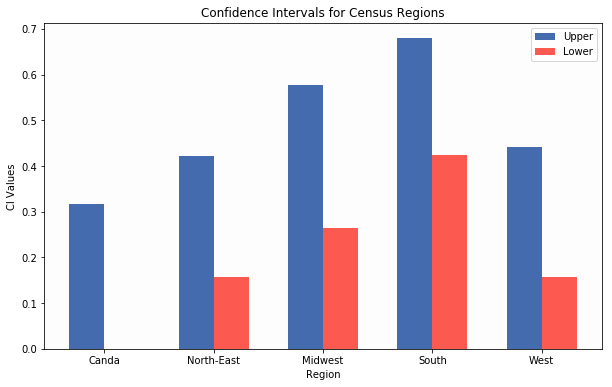

In [260]:
S = 5
upper_CI = (U, Norupper, Midupper, uciS, uciW)
lower_CI = (L, Norlower, Midlower, lciS, lciW)
fig, ax = plt.subplots(figsize=(10,6))
ind = np.arange(S) 
width = 0.32       
plt.bar(ind, upper_CI, width, label='Upper', color = "xkcd:french blue")
plt.bar(ind + width, lower_CI, width, label='Lower', color = "xkcd:coral")

plt.ylabel('CI Values')
plt.xlabel("Region")
plt.title('Confidence Intervals for Census Regions')

plt.xticks(ind + width / 2, ('Canda', 'North-East', 'Midwest', 'South', 'West'))
plt.legend(loc='best')
ax.set_facecolor('xkcd:pale grey')
plt.show()

**Conclusion**: From the data, I conclude that regional differneces do play a role in whether institutions offer paid parental leave to their professors. If we look at the Canadian CIs, we immediately notice that there is virtually no overlap with the CIs of other regions. Therefore, the pairwise comparison of Canada to other census regions indicates that there is a real difference. This also seems to be the case for the Southern region. Again, there is little or no overlap in that case when compared with other regions. 

However, there is a great deal of overlap with respect to other census regions, particularly in the North-Eastern and Western census regions. Therefore, it is very difficult to draw a meaningful conclusion about these census regions when comparing them with one another. There is also some overlap with the Midwest region and the other US regions, but the overlap in this case is not as pronounced as it is between, say, the West and North-East. 